In [4]:
!pip install --quiet torch torchvision torchaudio
!pip install --quiet jax jaxlib matplotlib escnn cliffordlayers lie_learn
!rm -rf /content/clifford-group-equivariant-cnns
!git clone https://github.com/maxxxzdn/clifford-group-equivariant-cnns.git /content/clifford-group-equivariant-cnns

Cloning into '/content/clifford-group-equivariant-cnns'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 228 (delta 32), reused 22 (delta 22), pack-reused 183 (from 2)
Receiving objects: 100% (228/228), 10.49 MiB | 15.61 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [5]:
import sys, os, re

repo_root = "/content/clifford-group-equivariant-cnns"

if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

target = os.path.join(repo_root, "algebra", "cliffordalgebra.py")

# force numpy usage
with open(target, "r") as f:
    code = f.read()

code = re.sub(r"import jax\.numpy as np", "import numpy as np", code)
code = re.sub(r"from jax import numpy as np", "import numpy as np", code)

if not code.startswith("import numpy as np"):
    code = "import numpy as np\n" + code

with open(target, "w") as f:
    f.write(code)

print("Patch OK")


Patch OK


In [6]:
import sys
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
print("Added to sys.path:", repo_root)

Added to sys.path: /content/clifford-group-equivariant-cnns


In [7]:
import numpy as np

In [8]:
from algebra.cliffordalgebra import CliffordAlgebra
algebra = CliffordAlgebra((1, 1))
print("CliffordAlgebra created:", type(algebra))
print("CliffordAlgebra created successfully:", algebra)

CliffordAlgebra created: <class 'algebra.cliffordalgebra.CliffordAlgebra'>
CliffordAlgebra created successfully: <algebra.cliffordalgebra.CliffordAlgebra object at 0x7c7f0c185a00>


In [9]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from algebra.cliffordalgebra import CliffordAlgebra
from modules.conv.kernel import CliffordSteerableKernel
from modules.conv.convolution import CliffordSteerableConv
from models.resnets import CSResNet

# 5️⃣ JAX configuration
jax.config.update("jax_enable_x64", False)

# 6️⃣ RNG seed
RNG_ID = 42

In [10]:
!pip uninstall -y lie_learn
!pip install git+https://github.com/AMLab-Amsterdam/lie_learn.git

Found existing installation: lie_learn 0.0.2
Uninstalling lie_learn-0.0.2:
  Successfully uninstalled lie_learn-0.0.2
  Cloning https://github.com/AMLab-Amsterdam/lie_learn.git to /tmp/pip-req-build-5rkjili3
  Running command git clone --filter=blob:none --quiet https://github.com/AMLab-Amsterdam/lie_learn.git /tmp/pip-req-build-5rkjili3
  Resolved https://github.com/AMLab-Amsterdam/lie_learn.git to commit edf012f5f60af320175d2e6269db78b984b5bfc3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lie_learn: filename=lie_learn-0.0.2-cp312-cp312-linux_x86_64.whl size=16619163 sha256=ff8fe1b1317b2b53b16e59baa8d89e724cdf10896ffb99a4f9742417f206ae87
  Stored in directory: /tmp/pip-ephem-wheel-cache-oxxl6yr4/wheels/9a/d5/a8/c322ed1cc39fbde8099da6173ba5cec9586c688d8cfdf592d1
Successfully built lie_learn


In [1]:
TEST_EQUIVARIANCE = True

if TEST_EQUIVARIANCE:
    import torch
    from escnn import gspaces, group

# Visualizing kernels

### Euclidean space $\mathbb{R}^{(2,0)}$

Let us demonstrate an example with (p,q) = (2,0), which is equivalent to familiar two-dimensional Euclidean vector space.

The signature corresponds to the metric matrix with ones along the diagonal, i.e. diag((1,1)). It is the diagonal elements of the metrix matrix that we use to initialize the key object - Clifford algebra - which containts all necessary basic attributes and methods for our case (e.g. geometric product).

Let us now visualize a single Clifford-steerable kernel with c_in = c_out = 1.

Since implicit kernels allow for arbitrary discretization, we use relatively high resolution. In practice, however, it will be much lower, e.g. 3x3, or 7x7x7.

In [14]:
import sys

sys.path.append("/content/clifford-group-equivariant-cnns")  # top-level
sys.path.append("/content/clifford-group-equivariant-cnns/algebra")
resolution = 128
from algebra.cliffordalgebra import CliffordAlgebra
algebra = CliffordAlgebra((1, 1))
config = dict(
    algebra=algebra,
    kernel_size=resolution,
    c_in=1,
    c_out=1,
    num_layers=4,
    hidden_dim=12,
    bias_dims=(0,),
    product_paths_sum=algebra.geometric_product_paths.sum().item(),
)

In [18]:
sys.path.append("/content/clifford-group-equivariant-cnns/modules/conv")
sys.path.append("/content/clifford-group-equivariant-cnns/models")


from modules.conv.kernel import CliffordSteerableKernel
from modules.conv.convolution import CliffordSteerableConv
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
RNG_ID = 42
kernel = CliffordSteerableKernel(**config)

# Initialize parameters
params = kernel.init(jax.random.PRNGKey(RNG_ID))

# Compute the kernel given the parameters
k = kernel.apply(params)

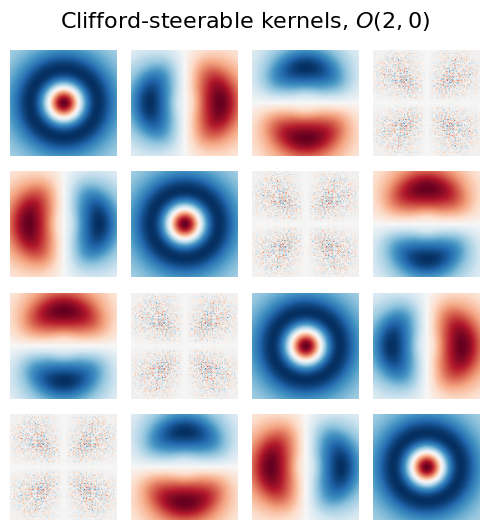

In [19]:
fig, ax = plt.subplots(4, 4, figsize=(5, 5))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow(k[i, j].T, cmap="RdBu")
        ax[i, j].axis("off")

fig.tight_layout()

fig.suptitle("Clifford-steerable kernels, $O(2,0)$", fontsize=16, y=1.05)
plt.show()

Note that pseudoscalar kernel is not exactly zero, but it has negligible magnitute of order 1e-9.

### Minkowski space $\mathbb{R}^{(1,1)}$

In this case, there are negative elements along the diagonal of the metric tensor.
Time-like dimensions are represented by positive elements in the metric tensor and space-like dimensions are represented by negative elements.

In [20]:
algebra = CliffordAlgebra((1, -1))

In [21]:
resolution = 128

config = dict(
    algebra=algebra,
    kernel_size=resolution,
    c_in=1,
    c_out=1,
    num_layers=4,
    hidden_dim=12,
    bias_dims=(0,),
    product_paths_sum=algebra.geometric_product_paths.sum().item(),
)

In [22]:
kernel = CliffordSteerableKernel(**config)

# Initialize parameters
params = kernel.init(jax.random.PRNGKey(RNG_ID))

# Compute the kernel given the parameters
k = kernel.apply(params)

We now plot the kernel, y-axis corresponds to time, x-axis to space

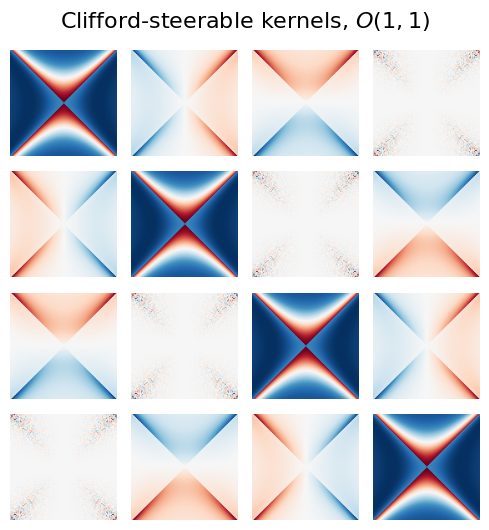

In [23]:
fig, ax = plt.subplots(4, 4, figsize=(5, 5))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow(k[i, j].T, cmap="RdBu")
        ax[i, j].axis("off")

fig.tight_layout()

fig.suptitle("Clifford-steerable kernels, $O(1,1)$", fontsize=16, y=1.05)
plt.show()

# Clifford-Steerable Convolution

Let us now initialize a convolutional layer and apply it to an input image.

In [24]:
algebra = CliffordAlgebra((1, 1))

config = dict(
    algebra=algebra,
    c_in=1,
    c_out=1,
    kernel_size=7,
    padding=True,
    num_layers=4,
    hidden_dim=12,
    bias_dims=(0,),
    product_paths_sum=algebra.geometric_product_paths.sum().item(),
)

In [25]:
csconv = CliffordSteerableConv(**config)

# random input for initialization
mv = jax.random.normal(jax.random.PRNGKey(RNG_ID), (16, 1, 64, 64, algebra.n_blades))
params = csconv.init(jax.random.PRNGKey(RNG_ID), mv)

Let us define our input multivector fields as follows:
- scalar: $sin(x) + cos(y)$
- vector: $\left[sin(x) sin(y), cos(x) cos(y)^2\right]$
- pseudoscalar: $cos(x) - sin(y)$


In [26]:
# Define the grid size
grid_size = 64

# Initialize the grid
x, y = jnp.meshgrid(
    jnp.linspace(0, 2 * jnp.pi, grid_size), jnp.linspace(0, 2 * jnp.pi, grid_size)
)

In [27]:
scalar = jnp.sin(x) + jnp.cos(y)
vector_x = jnp.sin(x) * jnp.sin(y)
vector_y = jnp.cos(x) + jnp.cos(y) ** 2
bivector = jnp.cos(x) - jnp.sin(y)

mv_field = jnp.stack([scalar, vector_x, vector_y, bivector], axis=-1)
mv_field = jnp.expand_dims(mv_field, axis=[0, 1])

In [28]:
# Apply the convolution
out = csconv.apply(params, mv_field)

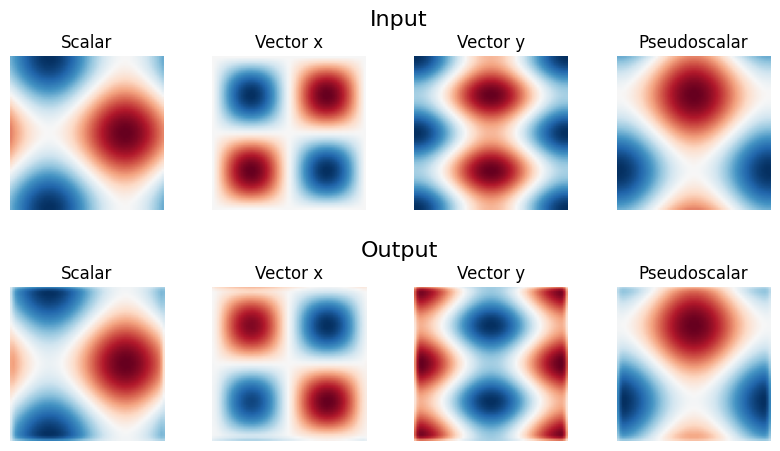

In [29]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y", "Pseudoscalar"]
channel = 2

for i in range(4):
    ax[0, i].imshow(mv_field[0, channel, :, :, i], cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])

for i in range(4):
    ax[1, i].imshow(out[0, channel, :, :, i], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(-0.1, 1.2, "Input", ha="center", fontsize=16, transform=ax[0, 2].transAxes)
plt.text(-0.1, 1.2, "Output", ha="center", fontsize=16, transform=ax[1, 2].transAxes)
plt.show()

### Test equivariance

Let us first define how separate components of the multivector field transform under rotations.

We test for O(2) group, which corresponds to gspaces.flipRot2dOnR2(-1) in escnn.

In [30]:
gspace = gspaces.flipRot2dOnR2(4)
scalar, pseudoscalar, vector = gspace.fibergroup.irreps()[
    :3
]  # multivector grades 0, 1, 2
representation = group.directsum(
    [scalar, vector, pseudoscalar]
)  # multivector representation is a direct sum of the irreps
mv_type = gspace.type(
    *[representation]
)  # this is the type of the field in the language of escnn

Next, lets define necessary machinery to translate from jax to escnn (pytorch) and back.

In [31]:
def to_geometric_tensor_torched(mv, ftype):
    """
    Converts a multivector jnp array to a torch tensor and defines the corresponding escnn' geometric tensor.

    Args:
        mv: jnp.array of shape (batch, channel, height, width, algebra.n_subspaces).
        ftype: escnn.FieldType, the type of the field.

    Returns:
        mv: escnn.GeometricTensor with tensor of shape (batch, channel*algebra.n_subspaces, height, width) and type ftype.
    """
    mv = torch.tensor(mv.__array__(), dtype=torch.float32)
    mv = mv.permute(0, 1, -1, 2, 3)
    mv = mv.reshape(mv.shape[0], -1, mv.shape[-2], mv.shape[-1])
    mv = mv_type(mv)
    return mv


def to_mv_jaxed(mv):
    """
    Converts a torch tensor to a multivector jnp array.

    Args:
        mv: escnn.GeometricTensor with tensor of shape (batch, channel*algebra.n_subspaces, height, width) and type ftype.

    Returns:
        mv: jnp.array of shape (batch, channel, height, width, algebra.n_subspaces).
    """
    mv = mv.tensor
    mv = mv.reshape(mv.shape[0], -1, 4, mv.shape[-2], mv.shape[-1])
    mv = mv.permute(0, 1, 3, 4, 2)
    mv = jnp.array(mv.numpy(), dtype=jnp.float32)
    return mv

We now convert our multivector array to a geometric tensor with the corresponding field type.

In [32]:
mv_gt = to_geometric_tensor_torched(mv_field, mv_type)

Let's pick a random group element (reflection + rotation) and apply it to the input multivector field.

In [33]:
g = list(gspace.testing_elements)[1]
mv_gt_transformed = mv_gt.transform(g)

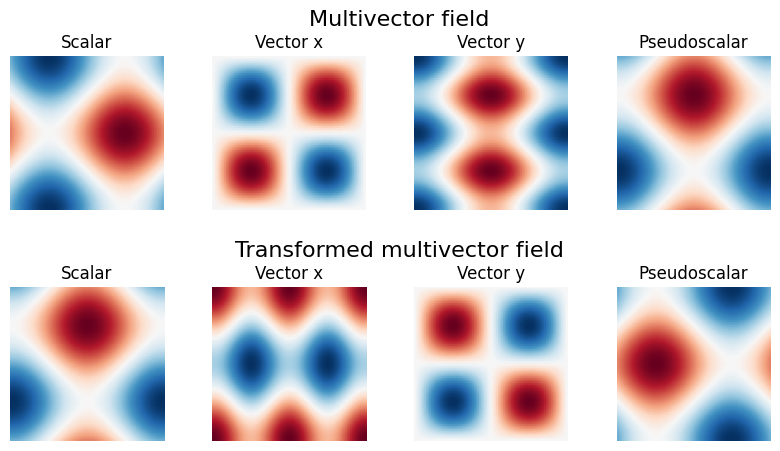

In [34]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y", "Pseudoscalar"]
channel = i

for i in range(4):
    ax[0, i].imshow(mv_gt.tensor[0, i, :, :], cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])

for i in range(4):
    ax[1, i].imshow(mv_gt_transformed.tensor[0, i, :, :], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(
    -0.1,
    1.2,
    "Multivector field",
    ha="center",
    fontsize=16,
    transform=ax[0, 2].transAxes,
)
plt.text(
    -0.1,
    1.2,
    "Transformed multivector field",
    ha="center",
    fontsize=16,
    transform=ax[1, 2].transAxes,
)
plt.show()

Let's now do the equivariance check. We want to assure that the transformation and the convolution commute.

We will do this by comparing $T(\mathcal{C}(x))$ with $\mathcal{C}(T(x))$, where $T$ is the transformation and $C$ is convolution.

In [38]:
import re, os

kernel_file = "/content/clifford-group-equivariant-cnns/modules/conv/kernel.py"

with open(kernel_file, "r") as f:
    code = f.read()

# Replace np.zeros/ones/array → enforce dtype=float32
code = re.sub(r"np.zeros\(([^)]*)\)", r"np.zeros(\1, dtype=np.float32)", code)
code = re.sub(r"np.ones\(([^)]*)\)", r"np.ones(\1, dtype=np.float32)", code)
code = re.sub(r"np.array\(([^)]*)\)", r"np.array(\1, dtype=np.float32)", code)

with open(kernel_file, "w") as f:
    f.write(code)

print("Patched kernel.py for float32")


Patched kernel.py for float32


In [39]:
import jax.tree_util

# ---- Utility to cast all float64 tensors to float32 ----
def cast_f32(tree):
    return jax.tree_util.tree_map(
        lambda x: x.astype(jnp.float32)
        if isinstance(x, jnp.ndarray) and x.dtype == jnp.float64
        else x,
        tree
    )

# --- convert params + inputs ---
params_f32 = cast_f32(params)
inp_f32 = cast_f32(to_mv_jaxed(mv_gt_transformed))

# --- rotation -> convolution ---
out_rotated_conv = to_geometric_tensor_torched(
    csconv.apply(params_f32, inp_f32), mv_type
).float()

# --- convolution -> rotation ---
out_conv_rotated = to_geometric_tensor_torched(out, mv_type).float().transform(g)


TypeError: lax.conv_general_dilated requires arguments to have the same dtypes, got float32, float64.

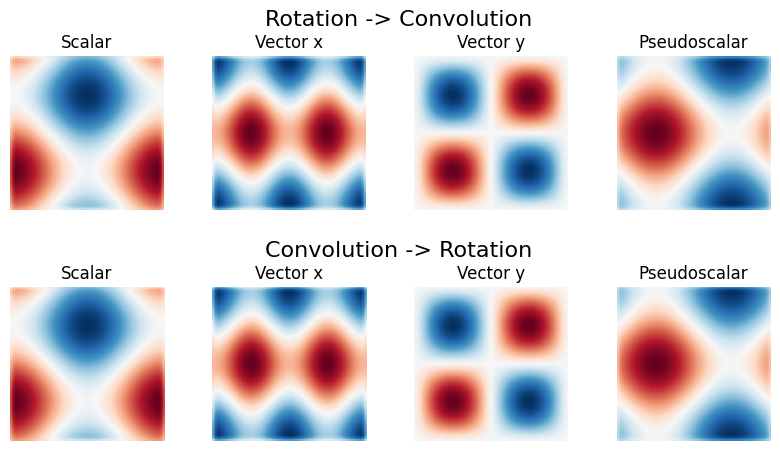

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y", "Pseudoscalar"]
channel = i

for i in range(4):
    ax[0, i].imshow(out_rotated_conv.tensor[0, i, :, :], cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])

for i in range(4):
    ax[1, i].imshow(out_conv_rotated.tensor[0, i, :, :], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(
    -0.1,
    1.2,
    "Rotation -> Convolution",
    ha="center",
    fontsize=16,
    transform=ax[0, 2].transAxes,
)
plt.text(
    -0.1,
    1.2,
    "Convolution -> Rotation",
    ha="center",
    fontsize=16,
    transform=ax[1, 2].transAxes,
)
plt.show()

In [ ]:
# Compute relative error
relative_error = torch.abs(
    out_rotated_conv.tensor - out_conv_rotated.tensor
) / torch.abs(out_rotated_conv.tensor + out_conv_rotated.tensor)

# display up to 5 decimal places
print(f"Relative error (mean): {relative_error.mean().item():.1e}")
print(f"Relative error (max): {relative_error.max().item():.1e}")

Relative error (mean): 7.4e-08
Relative error (max): 1.4e-05


# Clifford-Steerable ResNet

It is time to stack those layers together along some non-linearities and normalization layers into a CS-ResNet.

Since the model was originally developed for PDEs, it has time_history and time_future arguments, which essentially denote the number of input and output channels.

In [ ]:
algebra = CliffordAlgebra((1, 1))

config = dict(
    algebra=algebra,
    time_history=1,
    time_future=1,
    hidden_channels=13,
    kernel_num_layers=4,
    kernel_hidden_dim=12,
    kernel_size=7,
    bias_dims=(0,),
    product_paths_sum=algebra.geometric_product_paths.sum().item(),
    make_channels=1,
    blocks=(2, 2, 2, 2),
    norm=True,
    padding_mode="symmetric",
)

In [ ]:
csresnet = CSResNet(**config)

# random input for initialization
mv = jax.random.normal(jax.random.PRNGKey(RNG_ID), (16, 1, 64, 64, algebra.n_blades))
params = csresnet.init(jax.random.PRNGKey(RNG_ID), mv)

In [ ]:
# Apply the convolution
out = csresnet.apply(params, mv_field)

with multiple CS-ResNet blocks, the model finds quite interesting patterns. Let's plot them

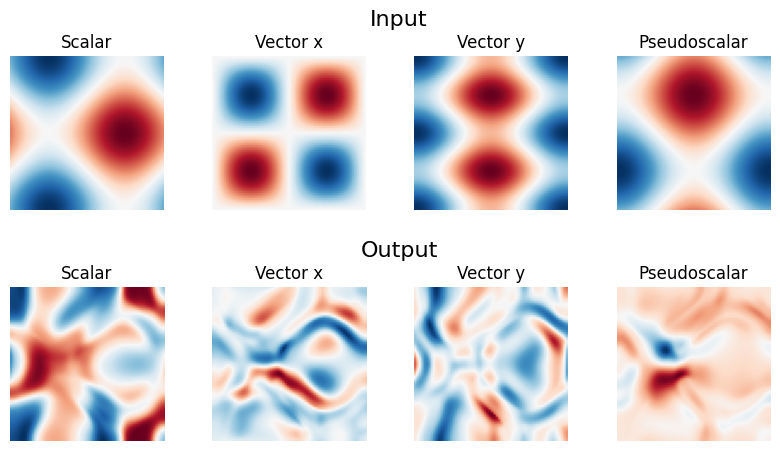

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y", "Pseudoscalar"]
channel = 2

for i in range(4):
    ax[0, i].imshow(mv_field[0, channel, :, :, i], cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])

for i in range(4):
    ax[1, i].imshow(out[0, channel, :, :, i], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(-0.1, 1.2, "Input", ha="center", fontsize=16, transform=ax[0, 2].transAxes)
plt.text(-0.1, 1.2, "Output", ha="center", fontsize=16, transform=ax[1, 2].transAxes)
plt.show()

Now its the time to test equivariance. We stick to the same example we used for a single convolution and hope for the best

In [ ]:
# 1) rotation -> 2) rotation
out_rotated_conv = to_geometric_tensor_torched(
    csresnet.apply(params, to_mv_jaxed(mv_gt_transformed)), mv_type
)

# 1) convolution -> 2) rotation
out_conv_rotated = to_geometric_tensor_torched(out, mv_type).transform(g)

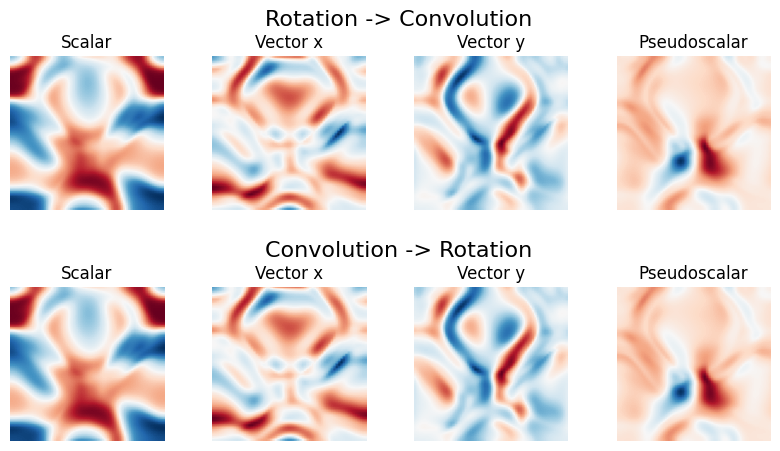

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y", "Pseudoscalar"]
channel = i

for i in range(4):
    ax[0, i].imshow(out_rotated_conv.tensor[0, i, :, :], cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])

for i in range(4):
    ax[1, i].imshow(out_conv_rotated.tensor[0, i, :, :], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(
    -0.1,
    1.2,
    "Rotation -> Convolution",
    ha="center",
    fontsize=16,
    transform=ax[0, 2].transAxes,
)
plt.text(
    -0.1,
    1.2,
    "Convolution -> Rotation",
    ha="center",
    fontsize=16,
    transform=ax[1, 2].transAxes,
)
plt.show()

In [ ]:
# Compute relative error
relative_error = torch.abs(
    out_rotated_conv.tensor - out_conv_rotated.tensor
) / torch.abs(out_rotated_conv.tensor + out_conv_rotated.tensor)

# display up to 5 decimal places
print(f"Relative error (mean): {relative_error.mean().item():.1e}")
print(f"Relative error (max): {relative_error.max().item():.1e}")

Relative error (mean): 2.3e-06
Relative error (max): 4.4e-03
